In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from IPython import display
from sklearn.model_selection import train_test_split
%matplotlib inline

import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
test_data = unpickle("data/cifar-10-batches-py/test_batch")

X_test = test_data[b'data']
X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:])) / 255.0
X_test = X_test.reshape(-1, 32, 32, 3)

In [9]:
b = X_test[...,::-1,:]

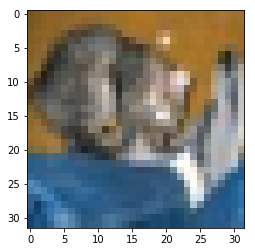

In [10]:
plt.imshow(b[0])

In [ ]:
## MODEL 2
# Create new graph
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = False
model_name = "model_2"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.004,                 # start at 0.005
                                               global_step, 
                                               20000,                 # decay by 0.3 in 25 epochs
                                               0.2,                   # 0.3 decrease
                                               staircase=False)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 32 filters
            kernel_size=(5, 5),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
            name='conv1'                  # Add name
        )

        # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        #apply relu
        conv1_bn_relu = tf.nn.relu(bn1, name='relu1')
    
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            conv1_bn_relu,                       # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
        
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            pool1,                           # Input data
            filters=64,                  # 32 filters
            kernel_size=(5, 5),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        #apply relu
        conv2_bn_relu = tf.nn.relu(bn2, name='relu2')
    
    with tf.name_scope('pool2') as scope:
         # Max pooling layer 1
        pool2 = tf.layers.max_pooling2d(
            conv2_bn_relu,                       # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool2,                       # Input
            filters=128,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=2),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
            name='conv3'                 # Add name
        )

        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        #apply relu
        conv3_bn_relu = tf.nn.relu(bn3, name='relu3')
        
    with tf.name_scope('pool3') as scope:
         # Max pooling layer 1
        pool3 = tf.layers.max_pooling2d(
            conv3_bn_relu,                       # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool3'
        )

        # try dropout here
        pool3 = tf.layers.dropout(pool3, rate=0.125, seed=1, training=training)
    

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            pool3,                       # Input
            filters=128,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=3),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
            name='conv4'                 # Add name
        )

        bn4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        #apply relu
        conv4_bn_relu = tf.nn.relu(bn4, name='relu4')
    
    with tf.name_scope('pool4') as scope:
         # Max pooling layer 2 (2x2, stride: 2) - TUNED
        pool4 = tf.layers.max_pooling2d(
            conv4_bn_relu,                       # input
            pool_size=(3, 3),            # pool size 3x3
            strides=(2, 2),              # stride 2
            padding='SAME',
            name="pool4"
        )


        # try dropout here
        pool4 = tf.layers.dropout(pool4, rate=0.125, seed=4, training=training)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool4)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                         # 256 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=5),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),
            name="fc1"
        )

        # dropout at 25%
        fc1 = tf.layers.dropout(fc1, rate=0.250, seed=6, training=training)
    
     # Fully connected layer 2
    with tf.name_scope('fc2') as scope:
        fc2 = tf.layers.dense(
            fc1,                 # input
            256,                         # 192 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='fc2'
        )

        # dropout at 25%
        fc2 = tf.layers.dropout(fc2, rate=0.25, seed=1, training=training)
    
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=7),
        bias_initializer=tf.zeros_initializer(),
        name="logits"
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [ ]:
## Model 4
# Create new graph
graph = tf.Graph()
model_name = "model_4"
init = False

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               2000,                # 2000 steps
                                               0.95,                 # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=32,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv1'                  # Add name
        )

         # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        relu1 = tf.nn.relu(bn1, name='relu1')
    
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            relu1,                           # Input data
            filters=32,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # apply relu
        relu2 = tf.nn.relu(bn2, name='relu2')
   
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            relu2,                       # Input
            pool_size=(2, 2),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv3'                 # Add name
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # apply relu
        relu3 = tf.nn.relu(bn3, name='relu3')

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            relu3,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv4'                 # Add name
        )

        # try batch normalization
        norm4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        # apply relu
        relu4 = tf.nn.relu(norm4, name='relu4')
    
    with tf.name_scope('pool2') as scope:
         # Max pooling layer 2 (2x2, stride: 2) - TUNED
        pool2 = tf.layers.max_pooling2d(
            relu4,                       # input
            pool_size=(2, 2),            # pool size 2x2
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool2)

        # dropout at 50%
        # flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=1, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                         # 256 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc1'
        )
        
        # dropout at 20%
        fc1 = tf.layers.dropout(fc1, rate=0.250, seed=1, training=training)
    
    # Output layer
    logits = tf.layers.dense(
        fc1,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [ ]:
## MODEL 7
# Create new graph
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = False
model_name = "model_7"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               2000,                # 2400 steps
                                               0.95,                # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-5
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 32 filters
            kernel_size=(5, 5),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv1'                 # Add name
        )

        # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=False,
            beta_initializer=tf.zeros_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        #apply relu
        conv1_bn_relu = tf.nn.relu(bn1, name='relu1')

        conv1_bn_relu = tf.layers.dropout(conv1_bn_relu, rate=0.1, seed=0, training=training)
    
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            conv1_bn_relu,                       # Input
            pool_size=(3, 3),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.1, seed=1, training=training)
             
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            pool1,                           # Input data
            filters=64,                  # 32 filters
            kernel_size=(5, 5),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=False,
            beta_initializer=tf.zeros_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        #apply relu
        conv2_bn_relu = tf.nn.relu(bn2, name='relu2')
    
    with tf.name_scope('pool2') as scope:
         # Max pooling layer 1
        pool2 = tf.layers.max_pooling2d(
            conv2_bn_relu,                       # Input
            pool_size=(3, 3),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool2'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool2, rate=0.1, seed=1, training=training)

    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=96,                  # 64 filters
            kernel_size=(4, 4),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv3'                 # Add name
        )

        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            beta_initializer=tf.zeros_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        #apply relu
        conv3_bn_relu = tf.nn.relu(bn3, name='relu3')

        conv3_bn_relu = tf.layers.dropout(conv3_bn_relu, rate=0.1, seed=2, training=training)
        
    with tf.name_scope('pool3') as scope:
         # Max pooling layer 1
        pool3 = tf.layers.max_pooling2d(
            conv3_bn_relu,                       # Input
            pool_size=(3, 3),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool3'
        )

        # try dropout here
        pool3 = tf.layers.dropout(pool3, rate=0.1, seed=1, training=training)
        
    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            pool3,                       # Input
            filters=96,                  # 64 filters
            kernel_size=(4, 4),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=2),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv4'                 # Add name
        )

        bn4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=False,
            beta_initializer=tf.zeros_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        #apply relu
        conv4_bn_relu = tf.nn.relu(bn4, name='relu4')
    
    # Max pooling layer 2 
    pool4 = tf.layers.max_pooling2d(
        conv4_bn_relu,                       # input
        pool_size=(3, 3),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME',
        name='pool2'
    )

    with tf.name_scope('conv5') as scope:
        # Convolutional layer 5
        conv5= tf.layers.conv2d(
            pool4,                       # Input
            filters=128,                 # 128 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=3),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv5'                 # Add name
        )

        bn5 = tf.layers.batch_normalization(
            conv5,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=False,
            beta_initializer=tf.zeros_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn5'
        )
        
        # activation
        conv5_bn_relu = tf.nn.relu(bn5, name='relu5')

        # try dropout here
        conv5_bn_relu = tf.layers.dropout(conv5_bn_relu, rate=0.1, seed=3, training=training)    

    # Max pooling layer 2 
    pool5 = tf.layers.max_pooling2d(
        conv5_bn_relu,                       # input
        pool_size=(2, 2),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME',
        name='pool5'
    )
        
    with tf.name_scope('conv6') as scope:
        # Convolutional layer 6
        conv6= tf.layers.conv2d(
            pool5,               # Input
            filters=128,                 # 128 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=4),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv6'                 # Add name
        )

        bn6 = tf.layers.batch_normalization(
            conv6,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=False,
            beta_initializer=tf.zeros_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn6'
        )

        #apply relu
        conv6_bn_relu = tf.nn.relu(bn6, name='relu6')
    
    # Max pooling layer 3
    pool6 = tf.layers.max_pooling2d(
        conv6_bn_relu,               # input
        pool_size=(2, 2),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME',
        name='pool6'
    )
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool6)

        ## TRY THIS
        # dropout at 20%
        flat_output = tf.layers.dropout(flat_output, rate=0.1, seed=5, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            1024,                        # 1024 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name="fc1"
        )
        
        # dropout at 10%
        fc1 = tf.layers.dropout(fc1, rate=0.10, seed=1, training=training)
    
    # Output layer
    logits = tf.layers.dense(
        fc1,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=6),
        bias_initializer=tf.zeros_initializer(),
        name="logits"
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries
    merged = tf.summary.merge_all()

In [ ]:
## MODEL 3
# Create new graph
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = True
model_name = "model_3"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.03,               # start at 0.03
                                               global_step, 
                                               500,                # 500 steps
                                               0.95,               # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=32,                  # 32 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv1'                 # Add name
        )

        # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        #apply relu
        conv1_bn_relu = tf.nn.relu(bn1, name='relu1')

        conv1_bn_relu = tf.layers.dropout(conv1_bn_relu, rate=0.1, seed=0, training=training)
    
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            conv1_bn_relu,                           # Input data
            filters=32,                  # 32 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        #apply relu
        conv2_bn_relu = tf.nn.relu(bn2, name='relu2')
    
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            conv2_bn_relu,                       # Input
            pool_size=(2, 2),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.1, seed=1, training=training)

    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv3'                 # Add name
        )

        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        #apply relu
        conv3_bn_relu = tf.nn.relu(bn3, name='relu3')

        conv3_bn_relu = tf.layers.dropout(conv3_bn_relu, rate=0.1, seed=2, training=training)

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            conv3_bn_relu,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=2),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv4'                 # Add name
        )

        bn4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        #apply relu
        conv4_bn_relu = tf.nn.relu(bn4, name='relu4')
    
    # Max pooling layer 2 
    pool2 = tf.layers.max_pooling2d(
        conv4_bn_relu,                       # input
        pool_size=(2, 2),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME',
        name='pool2'
    )

    with tf.name_scope('conv5') as scope:
        # Convolutional layer 5
        conv5= tf.layers.conv2d(
            pool2,                       # Input
            filters=128,                 # 128 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=3),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv5'                 # Add name
        )

        # activation
        conv5_bn_relu = tf.nn.relu(conv5, name='relu5')

        # try dropout here
        conv5_bn_relu = tf.layers.dropout(conv5_bn_relu, rate=0.1, seed=3, training=training)    

    with tf.name_scope('conv6') as scope:
        # Convolutional layer 6
        conv6= tf.layers.conv2d(
            conv5_bn_relu,               # Input
            filters=128,                 # 128 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=4),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv6'                 # Add name
        )

        bn6 = tf.layers.batch_normalization(
            conv6,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn6'
        )

        #apply relu
        conv6_bn_relu = tf.nn.relu(bn6, name='relu6')
    
    # Max pooling layer 3
    pool3 = tf.layers.max_pooling2d(
        conv6_bn_relu,               # input
        pool_size=(2, 2),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME',
        name='pool3'
    )
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool3)

        ## TRY THIS
        # dropout at 20%
        flat_output = tf.layers.dropout(flat_output, rate=0.1, seed=5, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            1024,                        # 1024 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name="fc1"
        )
        
        # dropout at 10%
        fc1 = tf.layers.dropout(fc1, rate=0.10, seed=1, training=training)
    
    # Output layer
    logits = tf.layers.dense(
        fc1,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=6),
        bias_initializer=tf.zeros_initializer(),
        name="logits"
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = optimizer.minimize(mean_ce, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [ ]:
## Model 10
# Create new graph
graph = tf.Graph()
model_name = "model_10"
init = False

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               3200,                # 2400 steps
                                               0.9,                 # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(5, 5),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv1'                  # Add name
        )

         # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        relu1 = tf.nn.relu(bn1, name='relu1')

    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            relu1,                       # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
        
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            pool1,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(5, 5),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # apply relu
        relu2 = tf.nn.relu(bn2, name='relu2')
   
    with tf.name_scope('pool2') as scope:
         # Max pooling layer 1
        pool2 = tf.layers.max_pooling2d(
            relu2,                       # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool2,                       # Input
            filters=96,                  # 96 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv3'                 # Add name
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # apply relu
        relu3 = tf.nn.relu(bn3, name='relu3')

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            relu3,                       # Input
            filters=96,                  # 96 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv4'                 # Add name
        )

        # try batch normalization
        norm4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        # apply relu
        relu4 = tf.nn.relu(norm4, name='relu4')
    
    with tf.name_scope('pool3') as scope:
        pool3 = tf.layers.max_pooling2d(
            relu4,                       # input
            pool_size=(2, 2),            # pool size 2x2
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool3'
        )

        # try dropout here
        pool3 = tf.layers.dropout(pool3, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool3)

        # dropout at 12.50%
        #flat_output = tf.layers.dropout(flat_output, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            784,                         # 784 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc1'
        )
        
        # dropout at 12.5%
        fc1 = tf.layers.dropout(fc1, rate=0.1250, seed=1, training=training)

    with tf.name_scope('fc2') as scope:
        # Fully connected layer
        fc2 = tf.layers.dense(
            fc1,                         # input
            392,                         # 392 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc2'
        )
        
        # dropout at 12.5%
        fc2 = tf.layers.dropout(fc2, rate=0.1250, seed=1, training=training)        
        
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()